In [ ]:
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Exploring ALOS PALSAR DATA IN PYTHON

In [ ]:
filepath= '/content/drive/MyDrive/Case_study/ALPSRP081490570-L1.1/ALPSRP081490570-L1.1/VOL-ALPSRP081490570-H1.1__A'

In [ ]:
palsar = gdal.Open(filepath)

In [ ]:
cols = palsar.RasterXSize
rows = palsar.RasterYSize
bands = palsar.RasterCount

In [ ]:
cols, rows, bands

(4640, 18432, 2)

In [ ]:
HH = palsar.GetRasterBand(1)
HV = palsar.GetRasterBand(2)

In [ ]:
HH_arr = HH.ReadAsArray()

In [ ]:
HV_arr = HV.ReadAsArray()

In [ ]:
HH_intensity = np.absolute(HH_arr)**2
HV_intensity = np.absolute(HV_arr)**2

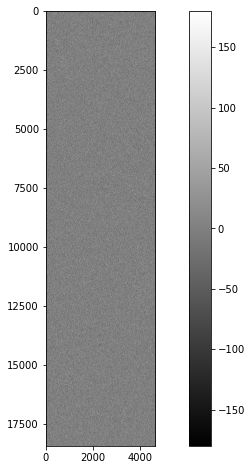

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
plt.imshow(np.angle(HH_arr, deg= True), cmap='gray')
plt.colorbar()

In [ ]:
HH_intensity = np.where(HH_intensity == 0.0,0.01,HH_intensity)
HV_intensity = np.where(HV_intensity == 0.0, 0.01, HV_intensity)

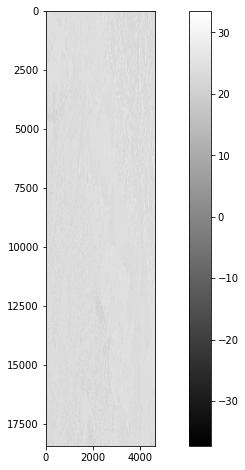

In [ ]:
fig, ax = plt.subplots(1,1,figsize= (12,8))
plt.imshow(np.log(np.flipud(HH_intensity)),cmap='gray')
plt.colorbar()

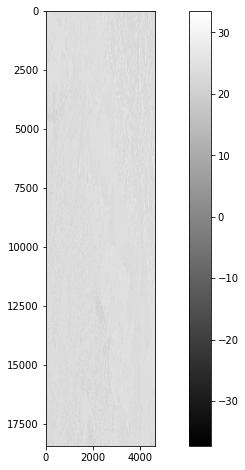

In [ ]:
fig

#### MULTILOOKING  OF SAR IMAGE


In [ ]:
# MULTILOOKING  OF SAR IMAGE
numlooks = 5 
ind = np.array(range(0,numlooks*math.floor((HH_arr.shape[0])/numlooks),numlooks))

In [ ]:
lookedHH = HH_arr[ind,:]
lookedHV = HV_arr[ind,:]

In [ ]:
for i in range(numlooks+1):
  for look in range(numlooks-1):
    lookedHH =lookedHH + HH_arr[ind +look,:]
    lookedHV = lookedHV + HV_arr[ind+look,:]

In [ ]:
sigmaHH = 10*np.log10(np.absolute(lookedHH)**2)-83-32
sigmaHV = 10*np.log10(np.absolute(lookedHV)**2)-83-32
sigmaHH_HV = sigmaHH - sigmaHV

In [ ]:
sigmaHH_norm = (np.max(sigmaHH)-sigmaHH)/(np.max(sigmaHH)-np.min(sigmaHH))
sigmaHV_norm = (np.max(sigmaHV)-sigmaHV)/(np.max(sigmaHV)-np.min(sigmaHV))
sigmaHH_HV_norm = (np.max(sigmaHH_HV)-sigmaHH_HV)/(np.max(sigmaHH_HV)-np.min(sigmaHH_HV))

In [ ]:
rgb = np.dstack((sigmaHH_norm,sigmaHV_norm,sigmaHH_HV_norm))

In [ ]:
fig, ax = plt.subplots(1,3,figsize =(14,12))
ax[0].imshow(sigmaHV[500:1500,2200:3000],cmap='gray')
ax[1].imshow(sigmaHH[500:1500,2200:3000],cmap='gray')
ax[2].imshow(rgb[500:1500,2200:3000],cmap='gray')

In [ ]:
plt.imsave('sigmaHV.png',np.flipud(sigmaHV),cmap='gray')
plt.imsave('sigmaHH.png',np.flipud(sigmaHH),cmap ='gray')

In [ ]:
from PIL import Image

In [ ]:
HV = Image.open('sigmaHV.png')
w, h = HV.size
cropHV = HV.crop((500,500,w-1000, h-2000))

In [ ]:
HH = Image.open('sigmaHH.png')
w, h = HH.size
cropHH = HH.crop((500,500,w-1000,h-2000))

In [ ]:
hvar = np.array(HV)
hhar = np.array(HH)

In [ ]:
hvar = hvar[:,:,1]
hhar = hhar[:,:,1]

In [ ]:
# Define median filter
def median_filter(data,kernel_size):
  indexer = kernel_size//2  # o/p largest possible integer
  padding = np.zeros((data.shape[0]+indexer,data.shape[1]+indexer))
  padding[indexer:padding.shape[0]-indexer+1,indexer:padding.shape[1]-indexer+1]= data
  for i in range(indexer,padding.shape[0]-indexer+1):
    for j in range(indexer,padding.shape[1]- indexer+1):
      padding[i,j] = np.median(padding[i-indexer:i + indexer+1, j- indexer:j + indexer +1])
      return padding

In [ ]:
medfil = median_filter(sigmaHH[500:1500,2200:3000],3)

NameError: ignored

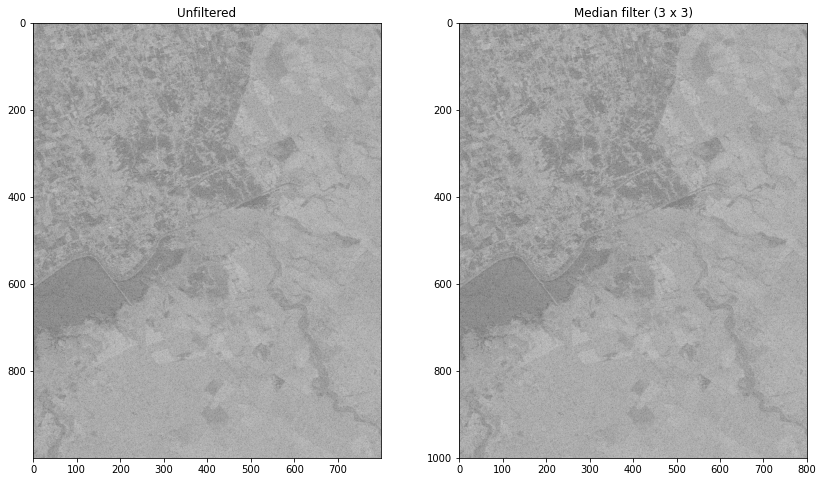

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(14,8))
ax[0].imshow(sigmaHH[500:1500,2200:3000],cmap='gray')
ax[0].title.set_text('Unfiltered')
ax[1].imshow(medfil,cmap='gray')
ax[1].title.set_text("Median filter (3 x 3)")

In [ ]:
# Define mean filter
def mean_filter(data,kernel_size):
  indexer = kernel_size//2  # o/p largest possible integer
  padding = np.zeros((data.shape[0]+indexer,data.shape[1]+indexer))
  padding[indexer:padding.shape[0]-indexer+1,indexer:padding.shape[1]-indexer+1]= data
  for i in range(indexer,padding.shape[0]-indexer+1):
    for j in range(indexer,padding.shape[1]- indexer+1):
      padding[i,j] = np.mean(padding[i-indexer:i + indexer+1, j- indexer:j + indexer +1])
      return padding

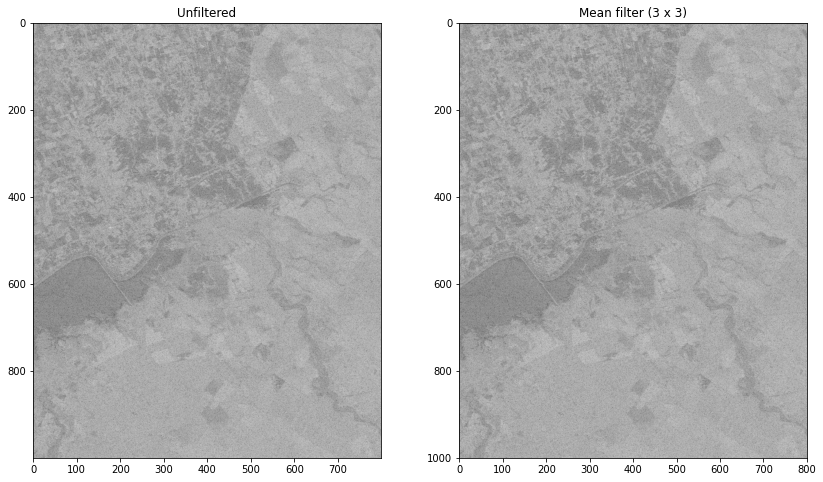

In [ ]:
meanfil = mean_filter(sigmaHH[500:1500,2200:3000],3)
fig,ax = plt.subplots(1,2,figsize=(14,8))
ax[0].imshow(sigmaHH[500:1500,2200:3000],cmap='gray')
ax[0].title.set_text('Unfiltered')
ax[1].imshow(medfil,cmap='gray')
ax[1].title.set_text("Mean filter (3 x 3)")

In [ ]:
from itertools import combinations_with_replacement
# UNDERSTAND ABOUT CONVOLUTION AND HOW IT DONE!
def convolution(oldimage, kernel):
  image_h = oldimage.shape[0]
  image_w = oldimage.shape[1]
  kernel_h = kernel.shape[0]
  kernel_w = kernel.shape[1]
  image_pad = np.pad(oldimage,pad_width = ((kernel_h//2, kernel_h//2),(kernel_w//2,kernel_w//2)),mode ='constant'
  , constant_values=0).astype(np.float32)

  h = kernel_h//2
  w = kernel_w//2

  image_conv = np.zeros(image_pad.shape)

  for i in range(h, image_pad.shape[0]-h):
    for j in range(w, image_pad.shape[1]-w):
      x = image_pad[i-h:i-h+kernel_h,j-w:j-w+kernel_w] 
      x = x.fiatten()*kernel.flatten()
      image_conv[i][j] = x.sum()
  h_end = -h
  w_end = -w
  if (h==0):
    return image_conv[h:,w:w_end]
  if (w==0):
    return image_conv[h:h_end,w:]
  return image_conv[h:h_end,w:w_end]



In [ ]:
def GaussianBlurImage(image,sigma):
  image = Image.fromarray(image)
  image = np.asarray(image)
  filter_size = int(4* sigma +0.5)+0.1
  gaussian_filter = np.zeros((filter_size,filter_size),np.float32)
  m = filter_size//2
  n = filter_size//2
  for x in range(-m, m+1):
    for y in range(-n,n+1):
      x1 = 2*np.pi*(sigma**2)
      x2 = np.exp(-(x**2+y**2)/(2*sigma**2))
      gaussian_filter[x+m, y+n] = (1/x1)*x2
  im_filtered = np.zeros_like(image, dtype= np.float32)
  im_filtered = convolution(image,gaussian_filter)
  return (im_filtered.astype(np.float32))

In [ ]:
Gaussian = GaussianBlurImage(sigmaHH[500:3500,2200:3000],3)

TypeError: ignored

In [ ]:
fig,ax = plt.subplots(1,2,figsize= (12,))